Name: plot_skewt.ipynb

Author: Robert M. Frost

NOAA Global Systems Laboratory

Created: 04 July 2023

Purpose: Plot skew-t soundings and hodographs of SRW output

In [23]:
import matplotlib.pyplot as plt
from UFSutils import read_grib
from metpy.plots import SkewT
from metpy.units import units
import metpy.calc as mpcalc
import numpy as np
import xarray as xr

Important parameters

In [24]:
# hour of interest
hr = 25
# directory where hrrr grib data are located
dskew_h = f"/scratch2/BMC/fv3lam/Robby.Frost/skewt_data/20230419/hrrr/skew_f{hr}.nc"
dskew_r = f"/scratch2/BMC/fv3lam/Robby.Frost/skewt_data/20230419/rap/skew_f{hr}.nc"

# desired latitude and longitude values
des_lat, des_lon = 32.432024, -96.995598

# directory for figure to be output
figdir = "/scratch2/BMC/fv3lam/Robby.Frost/figures/20230419/skewt/"

Use read_grib to retrieve valid_date

In [25]:
dgrib = "/scratch2/BMC/fv3lam/Robby.Frost/expt_dirs/2023041900_3km_hrrrphys/2023041900/postprd/"
valid_date = read_grib(hr, dgrib, "natlev", 1, ret_type=2)

Reading in /scratch2/BMC/fv3lam/Robby.Frost/expt_dirs/2023041900_3km_hrrrphys/2023041900/postprd/rrfs.t00z.natlev.f025.rrfs_conuscompact_3km.grib2
Finished reading in Pressure reduced to MSL


Read in 3d dataset

In [26]:
hrrr = xr.open_dataset(dskew_h)
# rap = xr.open_dataset(dskew_r)

Pull out position of interest

In [27]:
# pull lat/lon
lat = hrrr.north_south.values
lon = hrrr.west_east.values
# find index nearest to desired
lat_idx = np.argmin(np.abs(des_lat - lat[:,500]))
lon_idx = np.argmin(np.abs(des_lon - lon[840,:]))

Set arrays of temp, specific humidity, and pressure

In [28]:
# temperature
Th = hrrr.T[:,lat_idx,lon_idx]
# Tr = rap.T[:,lat_idx,lon_idx]
# specific humidity
qh = hrrr.q[:,lat_idx,lon_idx]
# qr = rap.q[:,lat_idx,lon_idx]
# pressure
ph = hrrr.p[:,lat_idx,lon_idx]
# pr = rap.pressure[:,lat_idx,lon_idx]

Unit Conversions

In [29]:
# convert to celsius
Th = Th - 273.15
# Tr = Tr - 273.15
# convert to hectopascals
ph = ph / 100
# pr = pr / 100

Calculate dew point

In [30]:
# calculate saturation vapor pressure for hrrr
Esh = (6.112 * np.exp(17.67 * Th)) / (Th + 243.5)
# calculate saturation vapor pressure for rap
# Esr = (6.112 * np.exp(17.67 * Tr)) / (Tr + 243.5)

# calculate vapor pressure for hrrr
Eh = (qh * ph) / (0.622 + 0.378 * qh)
# calculate vapor pressure for rap
# Er = (qr * pr) / (0.622 + 0.378 * qr)

# calculate dew point for hrrr
Tdh = (243.5 * np.log(Eh / 6.112)) / (17.67 - np.log(Eh / 6.112))
# calculate dew point for rap
# Tdr = (243.5 * np.log(Er / 6.112)) / (17.67 - np.log(Er / 6.112))

Calculate parcel path

In [31]:
# Assign units to temperature
Thu = units('celsius') * Th
# Tru = units('celsius') * Tr
# Assign units to dew point
Tdhu = units('celsius') * Tdh
# Tdru = units('celsius') * Tdr
# Assign units to pressure
phu = units('hPa') * ph
# pru = units('hPa') * pr

In [33]:
parcel_path = mpcalc.parcel_profile(phu, Thu[0], Tdhu[0])
parcel_path = parcel_path - (273.15 * units('kelvin'))

Plot HRRR skew-t

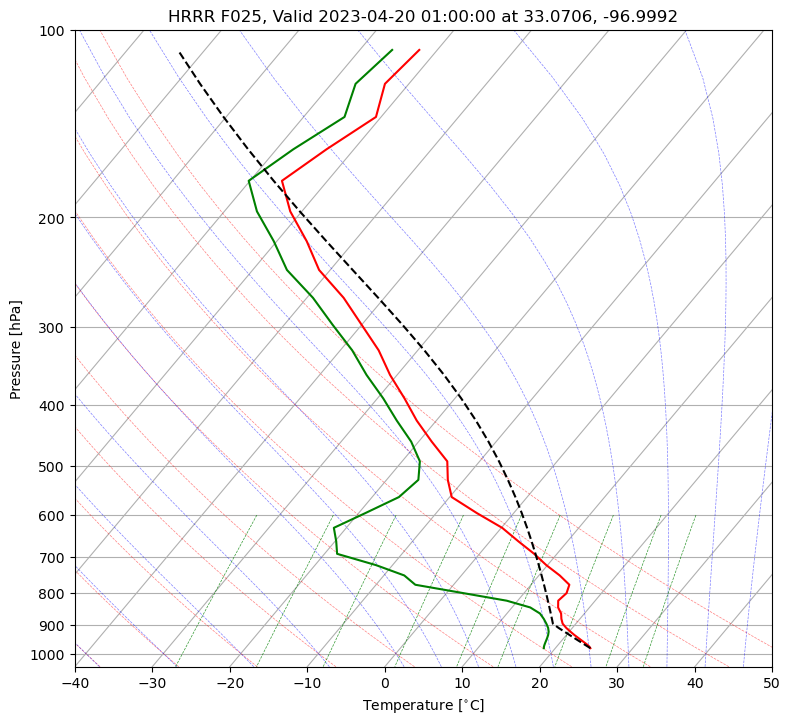

In [34]:
# create figure
fig = plt.figure(figsize=(9,9))

# plot skewt
skew = SkewT(fig, rotation=40)

# plot temp and dew point
skew.plot(ph, Th, 'red')
skew.plot(ph, Tdh, 'green')

# adiabats and mixing ratio
skew.plot_dry_adiabats(lw=0.5)
skew.plot_moist_adiabats(lw=0.5)
skew.plot_mixing_lines(lw=0.5)
# parcel path
skew.plot(ph, parcel_path, color="k", ls="--")

# axis titles
skew.ax.set_ylabel("Pressure [hPa]")
skew.ax.set_xlabel("Temperature [$^{\\circ}$C]")

# set figure title
skew.ax.set_title(f"HRRR F0{hr}, Valid {valid_date} at {round(lat[lat_idx,lon_idx],4)}, {round(lon[lon_idx,lon_idx],4)}")

# save fig
fsave = f"{figdir}hrrr_ f{hr}.png"
plt.savefig(fsave)
plt.show()
plt.close(fig)